Implementation Details
Data Collection and Preprocessing

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Electricity Visual/energy_consumption_last_month.csv')

# Preprocess data
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data['consumption_normalized'] = scaler.fit_transform(data[['consumption']])


Exploratory Data Analysis (EDA)

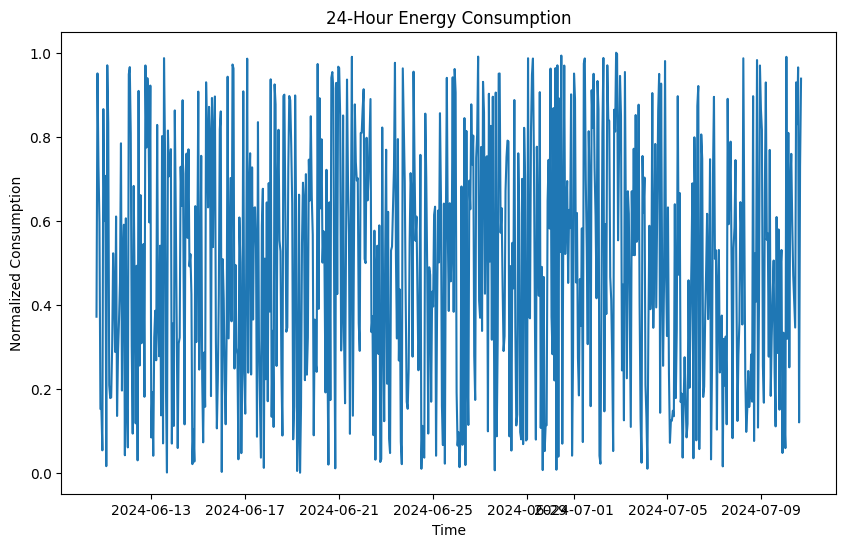

In [2]:
import matplotlib.pyplot as plt

# Visualize energy consumption
plt.figure(figsize=(10, 6))
plt.plot(data['consumption_normalized'])
plt.title('24-Hour Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Normalized Consumption')
plt.show()


Feature Engineering

In [3]:
# Example of adding time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

# One-hot encode categorical features
data = pd.get_dummies(data, columns=['day_of_week'], drop_first=True)


Model Building

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Ensure all columns are of type float
data[['hour', 'consumption_normalized'] + [col for col in data.columns if 'day_of_week' in col]] = data[['hour', 'consumption_normalized'] + [col for col in data.columns if 'day_of_week' in col]].astype(float)

# Prepare data for LSTM model
X = data[['hour', 'consumption_normalized'] + [col for col in data.columns if 'day_of_week' in col]].values
y = data['consumption_normalized'].shift(-1).fillna(0).values

# Ensure the target variable is of type float
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
18/18 [==============================] - 6s 146ms/step - loss: 0.2071 - val_loss: 0.0959
Epoch 2/20
18/18 [==============================] - 0s 9ms/step - loss: 0.1104 - val_loss: 0.1027
Epoch 3/20
18/18 [==============================] - 0s 8ms/step - loss: 0.1015 - val_loss: 0.0899
Epoch 4/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0978 - val_loss: 0.0918
Epoch 5/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0958 - val_loss: 0.0869
Epoch 6/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0942 - val_loss: 0.0900
Epoch 7/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0935 - val_loss: 0.0871
Epoch 8/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0925 - val_loss: 0.0898
Epoch 9/20
18/18 [==============================] - 0s 10ms/step - loss: 0.0918 - val_loss: 0.0859
Epoch 10/20
18/18 [==============================] - 0s 16ms/step - loss: 0.0914 - val_loss: 0.0850
Epoch 11/20
18

Forecasting

In [9]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)

print(f'MAE: {mae}, MSE: {mse}')


5/5 [==============================] - 1s 3ms/step
MAE: 0.6321923649517964, MSE: 0.5368164877237934


Optimization for Load Balancing

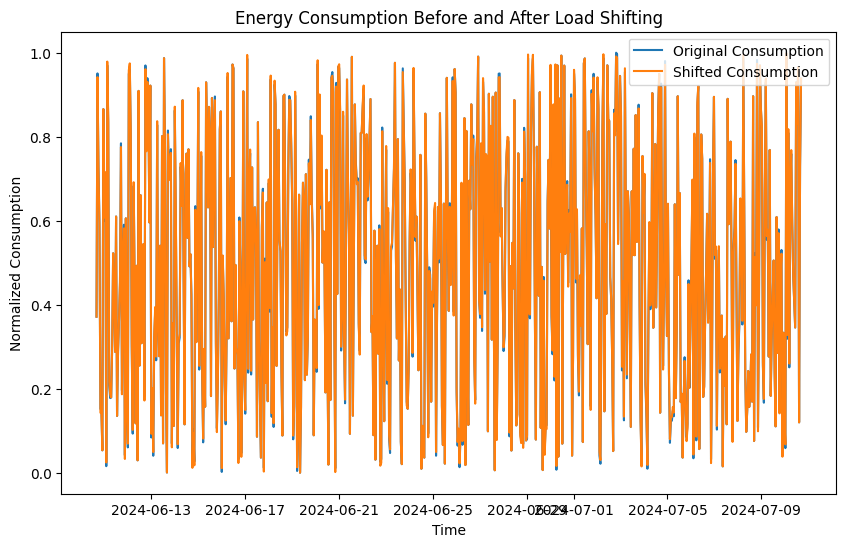

In [11]:
import numpy as np

# Simple example of load shifting strategy
def shift_load(consumption, peak_hours, off_peak_hours):
    shifted_consumption = consumption.copy()
    peak_consumption = np.mean(consumption[peak_hours])
    off_peak_consumption = np.mean(consumption[off_peak_hours])
    shift_amount = (peak_consumption - off_peak_consumption) / 2

    shifted_consumption[peak_hours] -= shift_amount
    shifted_consumption[off_peak_hours] += shift_amount
    return shifted_consumption

# Convert peak and off-peak hours to boolean arrays
peak_hours = (data['hour'] >= 17) & (data['hour'] <= 21)
off_peak_hours = (data['hour'] >= 0) & (data['hour'] <= 6)

data['shifted_consumption'] = shift_load(data['consumption_normalized'].values, peak_hours, off_peak_hours)

# Visualize the shifted load
plt.figure(figsize=(10, 6))
plt.plot(data['consumption_normalized'], label='Original Consumption')
plt.plot(data['shifted_consumption'], label='Shifted Consumption')
plt.title('Energy Consumption Before and After Load Shifting')
plt.xlabel('Time')
plt.ylabel('Normalized Consumption')
plt.legend()
plt.show()


To create a next 24-hour forecasting and load-shifting strategy, we can follow these steps:

Train the LSTM model to forecast the next 24 hours of energy consumption.
Apply the load-shifting strategy to the forecasted consumption to optimize energy usage.
Step 1: Forecasting the Next 24 Hours
First, let's extend the LSTM model training to predict the next 24 hours. We'll assume that we have already trained the model on historical data.

Step 2: Apply Load-Shifting Strategy
We'll apply a load-shifting strategy to the forecasted values to shift consumption from peak hours to off-peak hours.

Here's the implementation:

Epoch 1/20
18/18 [==============================] - 8s 85ms/step - loss: 0.1900 - val_loss: 0.1092
Epoch 2/20
18/18 [==============================] - 0s 10ms/step - loss: 0.1170 - val_loss: 0.1040
Epoch 3/20
18/18 [==============================] - 0s 6ms/step - loss: 0.1051 - val_loss: 0.0914
Epoch 4/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0996 - val_loss: 0.0917
Epoch 5/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0964 - val_loss: 0.0887
Epoch 6/20
18/18 [==============================] - 0s 5ms/step - loss: 0.0946 - val_loss: 0.0877
Epoch 7/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0934 - val_loss: 0.0885
Epoch 8/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0937 - val_loss: 0.0880
Epoch 9/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0923 - val_loss: 0.0857
Epoch 10/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0915 - val_loss: 0.0840
Epoch 11/20
18/1

<ipython-input-12-85a1806a1ed7>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[0, 0, -1] = next_value


1/1 [==============================] - 0s 20ms/step


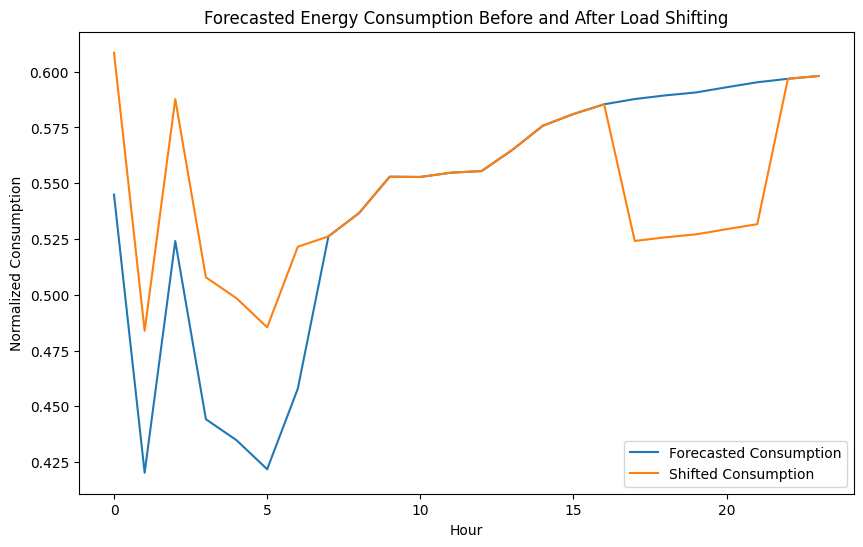

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Assuming 'data' is a DataFrame with 'timestamp', 'consumption', and 'consumption_normalized' columns
# Ensure all columns are of type float
data[['hour', 'consumption_normalized'] + [col for col in data.columns if 'day_of_week' in col]] = data[['hour', 'consumption_normalized'] + [col for col in data.columns if 'day_of_week' in col]].astype(float)

# Prepare data for LSTM model
X = data[['hour', 'consumption_normalized'] + [col for col in data.columns if 'day_of_week' in col]].values
y = data['consumption_normalized'].shift(-1).fillna(0).values

# Ensure the target variable is of type float
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Forecast the next 24 hours
def forecast_next_24_hours(model, last_observed_data):
    forecasted_consumption = []
    current_input = last_observed_data.reshape((1, 1, last_observed_data.shape[0]))

    for _ in range(24):
        next_value = model.predict(current_input)
        forecasted_consumption.append(next_value[0, 0])
        current_input = np.roll(current_input, -1)
        current_input[0, 0, -1] = next_value

    return np.array(forecasted_consumption)

last_observed_data = data[['hour', 'consumption_normalized'] + [col for col in data.columns if 'day_of_week' in col]].values[-1]
forecasted_consumption = forecast_next_24_hours(model, last_observed_data)

# Apply load shifting strategy
def shift_load(consumption, peak_hours, off_peak_hours):
    shifted_consumption = consumption.copy()
    peak_consumption = np.mean(consumption[peak_hours])
    off_peak_consumption = np.mean(consumption[off_peak_hours])
    shift_amount = (peak_consumption - off_peak_consumption) / 2

    shifted_consumption[peak_hours] -= shift_amount
    shifted_consumption[off_peak_hours] += shift_amount
    return shifted_consumption

# Define peak and off-peak hours for the forecasted period
forecasted_hours = np.arange(24)
peak_hours = (forecasted_hours >= 17) & (forecasted_hours <= 21)
off_peak_hours = (forecasted_hours >= 0) & (forecasted_hours <= 6)

shifted_forecasted_consumption = shift_load(forecasted_consumption, peak_hours, off_peak_hours)

# Visualize the forecasted and shifted load
plt.figure(figsize=(10, 6))
plt.plot(forecasted_consumption, label='Forecasted Consumption')
plt.plot(shifted_forecasted_consumption, label='Shifted Consumption')
plt.title('Forecasted Energy Consumption Before and After Load Shifting')
plt.xlabel('Hour')
plt.ylabel('Normalized Consumption')
plt.legend()
plt.show()


Explanation:
Training the LSTM model:

The LSTM model is trained on historical data to predict future consumption.
Forecasting the next 24 hours:

The function forecast_next_24_hours generates a 24-hour forecast based on the last observed data point.
Load Shifting:

The shift_load function shifts consumption from peak hours (17:00 to 21:00) to off-peak hours (00:00 to 06:00) by calculating the average consumption during these periods and adjusting accordingly.
Visualization:

The final plot visualizes the forecasted consumption and the shifted consumption to show the effect of the load-shifting strategy.